# Credit Risk Analysis - The Quantum Way

* Why do we need credit risk analysis - Basel II and Basel III
* The Montecarlo methods, where they fall. Their complexity
* Enter QAE - A quick and non rigourous analysis on Brassard, Grover and others work
* QAE for Credit risk - mapping probability distributions


Work based on the following papers:

- <a href="https://www.nature.com/articles/s41534-019-0130-6">Quantum Risk Analysis. Stefan Woerner, Daniel J. Egger.</a> [Woerner2019]
- <a href="https://arxiv.org/abs/1907.03044">Credit Risk Analysis using Quantum Computers. Egger et al. (2019)</a> [Egger2019]
- <a href="http://arxiv.org/abs/quant-ph/0005055">Quantum Amplitude Amplification and Estimation. Gilles Brassard et al.</a>
- And many others, check the references and bibliography and have a blast

### Problem Definition

In this tutorial we want to analyze the credit risk of a portfolio of $K$ assets.
The default probability of every asset $k$ follows a *Gaussian Conditional Independence* model, i.e., given a value $z$ sampled from a latent random variable $Z$ following a standard normal distribution, the default probability of asset $k$ is given by

$$p_k(z) = F\left( \frac{F^{-1}(p_k^0) - \sqrt{\rho_k}z}{\sqrt{1 - \rho_k}} \right) $$

where $F$ denotes the cumulative distribution function of $Z$, $p_k^0$ is the default probability of asset $k$ for $z=0$ and $\rho_k$ is the sensitivity of the default probability of asset $k$ with respect to $Z$. Thus, given a concrete realization of $Z$ the individual default events are assumed to be independent from each other.

We are interested in analyzing risk measures of the total loss

$$ L = \sum_{k=1}^K \lambda_k X_k(Z) $$

where $\lambda_k$ denotes the _loss given default_ of asset $k$, and given $Z$, $X_k(Z)$ denotes a Bernoulli variable representing the default event of asset $k$. More precisely, we are interested in the expected value $\mathbb{E}[L]$, the Value at Risk (VaR) of $L$ and the Conditional Value at Risk of $L$ (also called Expected Shortfall). Where VaR and CVaR are defined as

$$ \text{VaR}_{\alpha}(L) = \inf \{ x \mid \mathbb{P}[L <= x] \geq 1 - \alpha \}$$

with confidence level $\alpha \in [0, 1]$, and

$$ \text{CVaR}_{\alpha}(L) = \mathbb{E}[ L \mid L \geq \text{VaR}_{\alpha}(L) ].$$

For more details on the considered model, see, e.g.,<br>
<a href="https://arxiv.org/abs/1412.1183">Regulatory Capital Modeling for Credit Risk. Marek Rutkowski, Silvio Tarca</a>



The problem is defined by the following parameters:
- number of qubits used to represent $Z$, denoted by $n_z$
- truncation value for $Z$, denoted by $z_{\text{max}}$, i.e., Z is assumed to take $2^{n_z}$ equidistant values in $\{-z_{max}, ..., +z_{max}\}$ 
- the base default probabilities for each asset $p_0^k \in (0, 1)$, $k=1, ..., K$
- sensitivities of the default probabilities with respect to $Z$, denoted by $\rho_k \in [0, 1]$
- loss given default for asset $k$, denoted by $\lambda_k$
- confidence level for VaR / CVaR $\alpha \in [0, 1]$.

In [21]:
import numpy as np
import matplotlib.pyplot as plt


from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute, IBMQ
from qiskit.circuit.library import IntegerComparator, LinearAmplitudeFunction, WeightedAdder
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation, AmplitudeEstimation

from qiskit.finance.applications import GaussianConditionalIndependenceModel as GCI

from kaleidoscope import probability_distribution

IBMQ.load_account()
provider = IBMQ.get_provider()


ibmqfactory.load_account:WARNING:2021-02-17 13:47:01,016: Credentials are already in use. The existing account in the session will be replaced.


In [116]:
######################
# Problem parameters #
######################

# Each asset mapped as [default probability, sensitivity o the PDF, loss given default (expressed in '0.000)]

problem_size = 3

mortgages = [[0.1, 0.1, 200000],
             [0.2, 0.05, 150000],
             [0.3, 0.5, 200000],
             [0.02, 0.01, 400000],
             [0.05, 0.05, 300000],
             [0.2, 0.03, 390000],
             [0.01, 0.01, 100000],
             [0.03, 0.5, 120000]]

# Get only a subset when making the problem smaller
mortgages = mortgages[:problem_size]

# Confidence level for VaR and CVaR. On BaselII around 99,9%
alpha = 0.05

In [117]:
# Mapping parameters
# Loss Given Default multiplier (we can't map very big numbers, so we eliminate zeroes, from X00,000 -> X0)
lgd_factor = 100000

# Z represents our distribution, discretized with n qubits. The more qubits, the merrier. (I.e. the more values we will be able to approximate)
n_z = 2
z_max = 2
z_values = np.linspace(-z_max, z_max, 2**n_z)

K = len(mortgages)

probability_default = []
sensitivity_z = []
loss_given_default = []
for m in mortgages:
    probability_default.append(m[0])
    sensitivity_z.append(m[1])
    loss_given_default.append(int(m[2] / lgd_factor))   # LGD is simplified, reduced proportionately and taken only the integer part


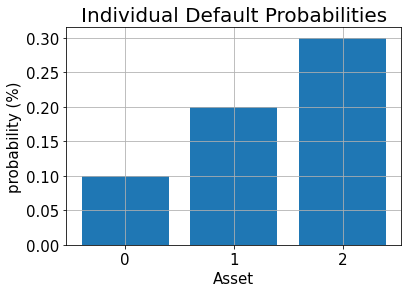

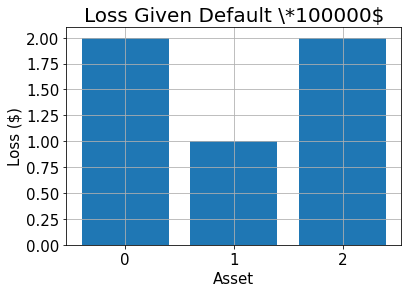

In [118]:
# plot results for default probabilities
plt.bar(range(K), probability_default)
plt.xlabel('Asset', size=15)
plt.ylabel('probability (%)', size=15)
plt.title('Individual Default Probabilities', size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

# plot Loss Given Defaults
plt.bar(range(K), loss_given_default)
plt.xlabel('Asset', size=15)
plt.ylabel('Loss ($)', size=15)
plt.title('Loss Given Default \*'+str(lgd_factor) +'$', size=20)
plt.xticks(range(K), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

# Part 1 - Build the model and test classically
_Start slow and easy_

### Uncertainty Model

We now construct a circuit that loads the uncertainty model. This can be achieved by creating a quantum state in a register of $n_z$ qubits that represents $Z$ following a standard normal distribution. This state is then used to control single qubit Y-rotations on a second qubit register of $K$ qubits, where a $|1\rangle$ state of qubit $k$ represents the default event of asset $k$. The resulting quantum state can be written as

$$ |\Psi\rangle = \sum_{i=0}^{2^{n_z}-1} \sqrt{p_z^i} |z_i \rangle \bigotimes_{k=1}^K \left( \sqrt{1 - p_k(z_i)}|0\rangle + \sqrt{p_k(z_i)}|1\rangle\right),$$

Where we denote by $z_i$ the $i$-th value of the discretized and truncated $Z$ [Egger2019].

In [119]:
uncertainty_model = GCI(n_z, z_max, probability_default, sensitivity_z) 

In [120]:
job = execute(uncertainty_model, backend=Aer.get_backend('statevector_simulator'))
probability_distribution(job.result().get_counts())

In [121]:
# analyze uncertainty circuit and determine exact solutions using Montecarlo over the circuit.
# We could compare with a fully classical MC modeling the GCI, but it is too difficult and I'm lazy

p_z = np.zeros(2**n_z)
p_default = np.zeros(K)
values = []
probabilities = []
num_qubits = uncertainty_model.num_qubits
for i, a in enumerate(job.result().get_statevector()):
    # get binary representation
    b = ('{0:0%sb}' % num_qubits).format(i)
    prob = np.abs(a)**2

    # extract value of Z and corresponding probability    
    # Note Z i mapped in the least significant n_z qubits. We add probabilities for each element in the distribution
    i_normal = int(b[-n_z:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k 
    # Most significant qubits represent 1 for default of that asset.
    loss = 0
    for k in range(K):
        if b[K - k - 1] == '1':
            p_default[k] += prob
            loss += loss_given_default[k]
    values += [loss]
    probabilities += [prob]   

values = np.array(values)
probabilities = np.array(probabilities)
    
# L = λ1*X1(Z) + λ2*X2(Z) + ... + λn*Xn(Z)
expected_loss = np.dot(values, probabilities)

losses = np.sort(np.unique(values))
pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1-alpha)
exact_var = losses[i_var]
exact_cvar = np.dot(pdf[(i_var+1):], losses[(i_var+1):])/sum(pdf[(i_var+1):])

# Calculate P[L <= VaR[L]]
alpha_point = np.where(values == exact_var)[0].min()
p_l_less_than_var = np.sum(probabilities[:alpha_point])

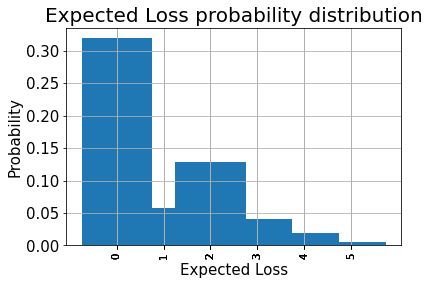

In [122]:
plt.bar(values, probabilities, width=1.5)
plt.xlabel('Expected Loss', size=15)
plt.ylabel('Probability', size=15)
plt.title('Expected Loss probability distribution', size=20)
plt.xticks(values, size=10, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.show()

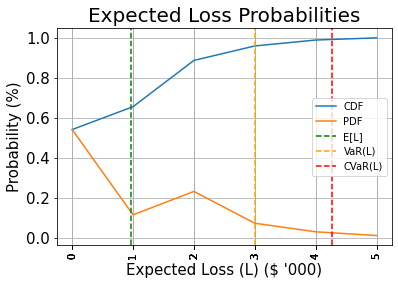

In [123]:
plt.plot(np.unique(values), cdf, label="CDF")
plt.plot(np.unique(values), pdf, label="PDF")
plt.xlabel('Expected Loss (L) ($ \'000)', size=15)
plt.ylabel('Probability (%)', size=15)
plt.title('Expected Loss Probabilities', size=20)
plt.xticks(values, size=10, rotation=90)
plt.yticks(size=15)
plt.axvline(expected_loss, color='green', linestyle='--', label='E[L]')
plt.axvline(exact_var, color='orange', linestyle='--', label='VaR(L)')
plt.axvline(exact_cvar, color='red', linestyle='--', label='CVaR(L)')
plt.legend()
plt.grid()
plt.show()


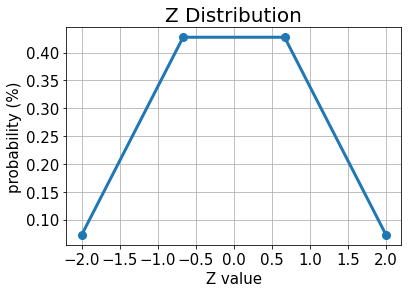

In [124]:
# plot results for Z
plt.plot(z_values, p_z, 'o-', linewidth=3, markersize=8)
plt.grid()
plt.xlabel('Z value', size=15)
plt.ylabel('probability (%)', size=15)
plt.title('Z Distribution', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [125]:

print('LGD: ', loss_given_default, ' Total Assets value: $ {0:12,.0f}'.format(sum(loss_given_default)*lgd_factor))
print('Assets: ', K)
print('Assets default Probabilities: ', probability_default)
print('Expected Loss E[L]:                $ {0:12,.0f}'.format(expected_loss*lgd_factor))
print('Value at Risk VaR[L](%.2f):        $ {0:12,.0f}'.format((exact_var*lgd_factor)) % (alpha))
print('P[L <= VaR[L]](%.2f):              %.4f' % (alpha, p_l_less_than_var))
print('Conditional Value at Risk CVaR[L]: $ {0:12,.0f}'.format(exact_cvar*lgd_factor))


LGD:  [2, 1, 2]  Total Assets value: $      500,000
Assets:  3
Assets default Probabilities:  [0.1, 0.2, 0.3]
Expected Loss E[L]:                $       96,732
Value at Risk VaR[L](0.05):        $      300,000
P[L <= VaR[L]](0.05):              0.6993
Conditional Value at Risk CVaR[L]: $      426,761


# Part 2 - Expected Loss with Quantum and QAE
_Bring it on_

# Enter QAE

![QAE Circuit](QAE.png)

A |0⟩n |0⟩ = √1−a|ψ0⟩n |0⟩+√a|ψ1⟩n |1⟩, (1)
where a ∈ [0, 1] is the unknown, and |ψ0 ⟩n and |ψ1 ⟩n are two normalized states, not necessarily orthogonal. QAE allows to estimate a with high probability such that the estimation error scales as O(1/M), where M corresponds to the number of applications of A. To this extent, an operator Q = −Sψ0A†S0A is defined where Sψ0 = I−2|ψ0⟩⟨ψ0|⊗|0⟩⟨0| and S0 = I−2|0⟩n+1 ⟨0|n+1

The probability of measuring |1⟩ in the last qubit is given by
P[|1⟩] = sin2((2k + 1)θa).



### QAE
Quantum Amplitude Estimation (QAE) is a fundamental quantum algorithm with the potential to achieve a quadratic speedup for many applications that are classically solved through Monte Carlo (MC) simulation.
While the estimation error of classical MC simulation scales as O(1/√M), where M denotes the number of (classical) samples, QAE achieves a scaling of O(1/M) for M (quantum) samples, which implies the aforementioned quadratic speedup.

The canonical version of QAE is a combination of Quantum Phase Estimation (QPE) and Grover’s Algorithm. Since other QPE-based algorithms are believed to achieve exponential speedup, most prominently Shor’s Algorithm for factoring [9], it has been speculated as to whether QAE can be simplified such that it uses only Grover iterations without a QPE-dependency. Removing the QPE-dependency would help to reduce the resource requirements of QAE in terms of qubits and circuit depth and lower the bar for practial applications of QAE.


### Expected Loss

To estimate the expected loss, we first apply a weighted sum operator to sum up individual losses to total loss:

$$ \mathcal{S}: |x_1, ..., x_K \rangle_K |0\rangle_{n_S} \mapsto |x_1, ..., x_K \rangle_K |\lambda_1x_1 + ... + \lambda_K x_K\rangle_{n_S}. $$

The required number of qubits to represent the result is given by

$$ n_s = \lfloor \log_2( \lambda_1 + ... + \lambda_K ) \rfloor + 1. $$

Once we have the total loss distribution in a quantum register, we can use the techniques described in [Woerner2019] to map a total loss $L \in \{0, ..., 2^{n_s}-1\}$ to the amplitude of an objective qubit by an operator

$$ | L \rangle_{n_s}|0\rangle \mapsto | L \rangle_{n_s} \left( \sqrt{1 - L/(2^{n_s}-1)}|0\rangle + \sqrt{L/(2^{n_s}-1)}|1\rangle \right),$$

which allows to run amplitude estimation to evaluate the expected loss.


Weighted Adder operator:

$$|q_0 \ldots q_{n-1}\rangle |0\rangle_s \mapsto |q_0 \ldots q_{n-1}\rangle |\sum_{j=0}^{n-1} \lambda_j q_j\rangle_s$$



                   ┌────────┐
          state_0: ┤0       ├ | state_0 * weights[0]
                   │        │ |
          state_1: ┤1       ├ | + state_1 * weights[1]
                   │        │ |
          state_2: ┤2       ├ | + state_2 * weights[2]
                   │        │ |
          state_3: ┤3       ├ | + state_3 * weights[3]
                   │        │
            sum_0: ┤4       ├ |
                   │  Adder │ |
            sum_1: ┤5       ├ | = sum_0 * 2^0 + sum_1 * 2^1 + sum_2 * 2^2
                   │        │ |
            sum_2: ┤6       ├ |
                   │        │
          carry_0: ┤7       ├
                   │        │
          carry_1: ┤8       ├
                   │        │
        control_0: ┤9       ├
                   └────────┘

In [32]:
# add Z qubits with weight/loss 0

# WeightedAdder(num_state_qubits=None, weights=None, name='adder')
# We need as many state qubits as our definition of Z + number of assets: |x1,...xk>|0>ns
# We only add weights to the lgd elements of the sum and add 0 to the Z (not really adding them)

weighted_adder = WeightedAdder(n_z + K, [0]*n_z + loss_given_default)



In [33]:
#weighted_adder.draw()
print(weighted_adder.num_qubits)

7


In [34]:
# Test Aggregator - Just to make sure we understand what it odes and why
# Lets do a quick test to validate the WeightedAdder Qiskit function

test_adder = WeightedAdder(4, [0,0,1,1])    # Adds only the last two state qubits


state_registry = QuantumRegister(test_adder.num_state_qubits, 'state')
sum_registry = QuantumRegister(test_adder.num_sum_qubits, 'sum')
carry_registry = QuantumRegister(test_adder.num_carry_qubits, 'carry')
sum_result = ClassicalRegister(test_adder.num_sum_qubits, 'sum_result')
carry_result = ClassicalRegister(test_adder.num_carry_qubits, 'carry_result')

if test_adder.num_control_qubits > 0:
    control_registry = QuantumRegister(test_adder.num_control_qubits, 'control')
    test_adder_circuit = QuantumCircuit(state_registry, sum_registry, carry_registry, control_registry, sum_result, carry_result)
else:
    test_adder_circuit = QuantumCircuit(state_registry, sum_registry, carry_registry, sum_result, carry_result)

test_adder_circuit.x(state_registry[0])
test_adder_circuit.x(state_registry[1])
test_adder_circuit.x(state_registry[2])
#test_adder_circuit.x(state_registry[3])

test_adder_circuit.append(test_adder, range(test_adder.num_qubits))
test_adder_circuit.measure(sum_registry, sum_result)
test_adder_circuit.measure(carry_registry, carry_result)
test_adder_circuit.draw()



┌───┐┌────────┐         
       state_0: ┤ X ├┤0       ├─────────
                ├───┤│        │         
       state_1: ┤ X ├┤1       ├─────────
                ├───┤│        │         
       state_2: ┤ X ├┤2       ├─────────
                └───┘│        │         
       state_3: ─────┤3 adder ├─────────
                     │        │┌─┐      
         sum_0: ─────┤4       ├┤M├──────
                     │        │└╥┘┌─┐   
         sum_1: ─────┤5       ├─╫─┤M├───
                     │        │ ║ └╥┘┌─┐
       carry_0: ─────┤6       ├─╫──╫─┤M├
                     └────────┘ ║  ║ └╥┘
  sum_result: 2/════════════════╩══╩══╬═
                                0  1  ║ 
                                      ║ 
carry_result: 1/══════════════════════╩═
                                      0

In [35]:
job = execute(test_adder_circuit, backend=Aer.get_backend('statevector_simulator'))
probability_distribution(job.result().get_counts())

### Linear Amplitude Function 

CLASSLinearAmplitudeFunction(num_state_qubits, slope, offset, domain, image, rescaling_factor=1, breakpoints=None, name='F')

A circuit implementing a (piecewise) linear function on qubit amplitudes.

An amplitude function 𝐹 of a function 𝑓 is a mapping
$$F|x\rangle|0\rangle = \sqrt{1 - \hat{f}(x)} |x\rangle|0\rangle + \sqrt{\hat{f}(x)} |x\rangle|1\rangle.$$

for a function $ \hat{f}: \{0, ..., 2^n - 1\} \rightarrow [0, 1] $, where |𝑥⟩ is a $n$ qubit state.

This circuit implements F for piecewise linear functions $\hat{f}$. In this case, the mapping F can be approximately implemented using a Taylor expansion and linearly controlled Pauli-Y rotations. This approximation uses a rescaling_factor to determine the accuracy of the Taylor expansion.

In general, the function of interest f is defined from some interval $[a,b]$, 'domain' to $ [c,d]$, the 'image', instead of $ \{1, ..., N\} $ to $[0, 1]$. Usng an affine transformation we can rescale $f$ to $ \hat{f} $ :

$$\hat{f(x)} = \frac{f(\phi(x)) - c}{d - c}$$

with

$\phi(x) = a + \frac{b - a}{2^n - 1} x$

If $ f $ is a piecewise linear function on 'm' intervals $ [p_{i-1}, p_i], i \in \{1, ..., m\} $ with slopes $ \alpha_i $ and offsets $ \beta_i $ it can be written as

$$f(x) = \sum_{i=1}^m 1_{[p_{i-1}, p_i}(x) (\alpha_i x + \beta_i)$$

where $ 1_[a, b] $ is an indication function that is 1 if the argument is in the interval $ [a, b] $ and otherwise 0. The breakpoints $ p_i $ can be specified by the 'breakpoints' argument.

In [169]:

# define linear objective function
breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(loss_given_default)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    weighted_adder.num_sum_qubits,
    slope=slopes, 
    offset=offsets, 
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2**weighted_adder.num_sum_qubits-1),  
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
    name="F"
)

In [170]:
objective.decompose().draw()

q751_0: ─────────────────■─────────────────────────────
                         │                             
q751_1: ─────────────────┼───────────■─────────────────
                         │           │                 
q751_2: ─────────────────┼───────────┼───────────■─────
        ┌──────────┐┌────┴─────┐┌────┴─────┐┌────┴────┐
q752_0: ┤ RY(3π/8) ├┤ RY(π/20) ├┤ RY(π/10) ├┤ RY(π/5) ├
        └──────────┘└──────────┘└──────────┘└─────────┘

In [171]:
job = execute(objective, backend=Aer.get_backend('statevector_simulator'))
probability_distribution(job.result().get_counts())

## Put everything together for the state preparation

In [172]:
# define the registers for convenience and readability
qr_state = QuantumRegister(uncertainty_model.num_qubits, 'state')
qr_sum = QuantumRegister(weighted_adder.num_sum_qubits, 'sum')
qr_carry = QuantumRegister(weighted_adder.num_carry_qubits, 'carry')
qr_obj = QuantumRegister(1, 'objective')
qr_control = QuantumRegister(1, 'control')


# define the circuit
if weighted_adder.num_control_qubits > 0:
    state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, qr_control, name='A')
    state_preparation.append(uncertainty_model.to_gate(), qr_state)
    state_preparation.append(weighted_adder.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])
    state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])
    state_preparation.append(weighted_adder.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:] + qr_control[:])
else: 
    state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry, name='A')
    state_preparation.append(uncertainty_model.to_gate(), qr_state)
    state_preparation.append(weighted_adder.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:])
    state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])
    state_preparation.append(weighted_adder.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:])


# draw the circuit
state_preparation.draw()

┌───────┐┌─────────┐      ┌────────────┐
    state_0: ┤0      ├┤0        ├──────┤0           ├
             │       ││         │      │            │
    state_1: ┤1      ├┤1        ├──────┤1           ├
             │       ││         │      │            │
    state_2: ┤2 P(X) ├┤2        ├──────┤2           ├
             │       ││         │      │            │
    state_3: ┤3      ├┤3        ├──────┤3           ├
             │       ││         │      │            │
    state_4: ┤4      ├┤4        ├──────┤4           ├
             └───────┘│         │┌────┐│            │
objective_0: ─────────┤         ├┤3   ├┤            ├
                      │   adder ││    ││   adder_dg │
      sum_0: ─────────┤5        ├┤0   ├┤5           ├
                      │         ││  F ││            │
      sum_1: ─────────┤6        ├┤1   ├┤6           ├
                      │         ││    ││            │
      sum_2: ─────────┤7        ├┤2   ├┤7           ├
                      │         │└────┘│            │
    carry_0: ─────────┤8        ├──────┤8           ├
                      │         │      │            │
    carry_1: ─────────┤9        ├──────┤9           ├
                      │         │      │            │
  control_0: ─────────┤10       ├──────┤10          ├
                      └─────────┘      └────────────┘

In [49]:
from qiskit import transpile
print("Required Qubits: ", state_preparation.decompose().num_qubits)

backend = Aer.get_backend('qasm_simulator')
optimized_0 = transpile(state_preparation, backend=backend, seed_transpiler=11, optimization_level=0)
print("No Optimization")
print('gates = ', optimized_0.count_ops())
print('depth = ', optimized_0.depth())

optimized_3 = transpile(state_preparation, backend=backend, seed_transpiler=11, optimization_level=3)
print("High Optimization")
print('gates = ', optimized_3.count_ops())
print('depth = ', optimized_3.depth())

Required Qubits:  8
No Optimization
gates =  OrderedDict([('cx', 18), ('u3', 12), ('ccx', 12), ('x', 8), ('ry', 6)])
depth =  36
High Optimization
gates =  OrderedDict([('cx', 82), ('tdg', 36), ('t', 36), ('h', 14), ('u3', 12), ('x', 8), ('ry', 6), ('u1', 2)])
depth =  136


In [173]:
job = execute(state_preparation, backend=Aer.get_backend('statevector_simulator'))

In [174]:
probability_distribution(job.result().get_counts())

## Test clasically


We evaluate going throughn the samples the probability of finding |1>
In principle the QAE or IQAE should approximate such value. _(This might take a while to run... you are going through all samples my friend)_

In [175]:
# evaluate resulting statevector
value = 0
for i, a in enumerate(job.result().get_statevector()):
    b = ('{0:0%sb}' % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1):]
    am = np.round(np.real(a), decimals=4)
    if np.abs(am) > 1e-6 and b[0] == '1':
        value += am**2

In [176]:

print('Exact Expected Loss:   $ {0:12,.0f}'.format(expected_loss*lgd_factor))
print('Exact Operator Value (probability):  %.4f' % value)
print('Mapped Operator value: $ {0:12,.0f}'.format(objective.post_processing(value)*lgd_factor))

Exact Expected Loss:   $       96,732
Exact Operator Value (probability):  0.3824
Mapped Operator value: $      100,264


In [54]:
state_preparation.num_qubits

8

In [55]:

# Where do we want to run it?
#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')

# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

# construct amplitude estimation 
iae = IterativeAmplitudeEstimation(state_preparation=state_preparation,
                                  epsilon=epsilon, alpha=alpha,
                                  objective_qubits=[len(qr_state)],
                                  post_processing=objective.post_processing)
result = iae.run(quantum_instance=backend, shots=100)


In [56]:
conf_int = np.array(result['confidence_interval'])
print('Exact value:   $ {0:9,.0f}'.format(expected_loss*lgd_factor))
print('Estimated value: $ {0:9,.0f}'.format(result['estimation']*lgd_factor))
print('Confidence interval: \t[%.0f, %.0f]' % (tuple(conf_int*lgd_factor)))

Exact value:   $    29,294
Estimated value: $    31,622
Confidence interval: 	[30496, 32748]


In [57]:
# TODO
# - Run with QAE standard and test estimated value and confidence
# - Parametrize circuit
# - Use QSVM to get real parameters and estimate rho's

In [61]:
# Try with "standard" QAE and see what happens

# AmplitudeEstimation(num_eval_qubits, state_preparation=None, grover_operator=None, objective_qubits=None, post_processing=None, phase_estimation_circuit=None, iqft=None, quantum_instance=None, a_factory=None, q_factory=None, i_objective=None)

evaluation_qubits = 7
ae = AmplitudeEstimation(evaluation_qubits, state_preparation=state_preparation)
ia_real_result = ae.run(quantum_instance=backend, shots=1000)

In [62]:
conf_int = np.array(ia_real_result['confidence_interval'])
print('Exact value:   $ {0:9,.0f}'.format(expected_loss*lgd_factor))
print('Estimated value: $ {0:9,.0f}'.format(ia_real_result['estimation']*lgd_factor))
print('Confidence interval: \t[%.0f, %.0f]' % (tuple(conf_int*lgd_factor)))

Exact value:   $    29,294
Estimated value: $         0
Confidence interval: 	[0, 0]


In [60]:
ia_real_result

{'a_estimation': 0.0, 'confidence_interval': [0.0, 5.631543062104302e-06], 'estimation': 0.0, 'num_oracle_queries': 31000, 'ml_value': 0.0, 'mapped_a_samples': [0.0], 'probabilities': [1.0], 'shots': 1000, 'mle': 0.0, 'circuit_result': {'00000': 1000}, 'a_samples': [(0.0, 1.0)], 'y_measurements': [(0, 1.0)], 'mapped_values': [0.0], 'max_probability': 1.0}

## Great, now what?

The expected loss is fine, but this is very easy to calculate even with an excel spreadsheet. However estimating the Cumulative Distribution Function is another story. Classically we would need a very expensive Montecarlo that grows exponentially with the size of the problem.

![CDF Calculation using the Unitary, the weighted adder and the comparator](CDF_calculation_quantum_risk.png)

The CDF(𝑥) equals the probability of measuring |1⟩ in the objective qubit and QAE can be directly used to estimate it.

In [85]:
# We use an IntegerComparator
# IntegerComparator(num_state_qubits=None, value=None, geq=True, name='cmp')
# Operator compares basis states |𝑖⟩𝑛 against a classically given integer 𝐿 of fixed value and flips a target qubit if 𝑖≥𝐿 (or < depending on the parameter geq):

# So basically we compare the sum from before with value that has L on the objective_qubit.

comparator_value = 2

comparator = IntegerComparator(weighted_adder.num_sum_qubits, comparator_value + 1, geq=False)
comparator.draw()

state_0: ──■──────────────■──
             │              │  
  state_1: ──┼────■─────────┼──
             │  ┌─┴─┐┌───┐  │  
compare_0: ──┼──┤ X ├┤ X ├──┼──
           ┌─┴─┐└─┬─┘└───┘┌─┴─┐
    a14_0: ┤ X ├──■───────┤ X ├
           └───┘          └───┘

In [165]:
def build_cdf_state_preparation(comparator_value, uncertainty_model, weighted_adder):
    cdf_qr_state = QuantumRegister(uncertainty_model.num_qubits, 'state')
    cdf_qr_sum = QuantumRegister(weighted_adder.num_sum_qubits, 'sum')
    cdf_qr_carry = QuantumRegister(weighted_adder.num_carry_qubits, 'carry')
    cdf_qr_obj = QuantumRegister(1, 'objective')
    cdf_qr_compare = QuantumRegister(1, 'compare')
    cdf_qr_control = QuantumRegister(weighted_adder.num_control_qubits, 'control')
    
    comparator = IntegerComparator(weighted_adder.num_sum_qubits, comparator_value + 1, geq=False)

    if weighted_adder.num_control_qubits > 0:
        cdf_state_preparation = QuantumCircuit(cdf_qr_state, cdf_qr_obj, cdf_qr_sum, cdf_qr_carry, cdf_qr_control, name='A')
        cdf_state_preparation.append(uncertainty_model, cdf_qr_state)
        cdf_state_preparation.append(weighted_adder, cdf_qr_state[:] + cdf_qr_sum[:] + cdf_qr_carry[:] + cdf_qr_control[:])
        cdf_state_preparation.append(comparator, cdf_qr_sum[:] + cdf_qr_obj[:] + cdf_qr_carry[:])
        cdf_state_preparation.append(weighted_adder.inverse(), cdf_qr_state[:] + cdf_qr_sum[:] + cdf_qr_carry[:] + cdf_qr_control[:])
    else:
        cdf_state_preparation = QuantumCircuit(cdf_qr_state, cdf_qr_obj, cdf_qr_sum, cdf_qr_carry, name='A')
        cdf_state_preparation.append(uncertainty_model, cdf_qr_state)
        cdf_state_preparation.append(weighted_adder, cdf_qr_state[:] + cdf_qr_sum[:] + cdf_qr_carry[:])
        cdf_state_preparation.append(comparator, cdf_qr_sum[:] + cdf_qr_obj[:] + cdf_qr_carry[:])
        cdf_state_preparation.append(weighted_adder.inverse(), cdf_qr_state[:] + cdf_qr_sum[:] + cdf_qr_carry[:])
        cdf_state_preparation.append(weighted_adder.inverse(), cdf_qr_state[:] + cdf_qr_sum[:] + cdf_qr_carry[:])
    
    return cdf_state_preparation

weighted_adder = WeightedAdder(n_z + K, [0]*n_z + loss_given_default)
comparator_value = 1
cdf_state_preparation = build_cdf_state_preparation(comparator_value, uncertainty_model, weighted_adder)
cdf_state_preparation.draw()


┌───────┐┌─────────┐        ┌────────────┐
    state_0: ┤0      ├┤0        ├────────┤0           ├
             │       ││         │        │            │
    state_1: ┤1      ├┤1        ├────────┤1           ├
             │       ││         │        │            │
    state_2: ┤2 P(X) ├┤2        ├────────┤2           ├
             │       ││         │        │            │
    state_3: ┤3      ├┤3        ├────────┤3           ├
             │       ││         │        │            │
    state_4: ┤4      ├┤4        ├────────┤4           ├
             └───────┘│         │┌──────┐│            │
objective_0: ─────────┤         ├┤3     ├┤            ├
                      │   adder ││      ││   adder_dg │
      sum_0: ─────────┤5        ├┤0     ├┤5           ├
                      │         ││      ││            │
      sum_1: ─────────┤6        ├┤1     ├┤6           ├
                      │         ││  cmp ││            │
      sum_2: ─────────┤7        ├┤2     ├┤7           ├
                      │         ││      ││            │
    carry_0: ─────────┤8        ├┤4     ├┤8           ├
                      │         ││      ││            │
    carry_1: ─────────┤9        ├┤5     ├┤9           ├
                      │         │└──────┘│            │
  control_0: ─────────┤10       ├────────┤10          ├
                      └─────────┘        └────────────┘

In [166]:
job = execute(cdf_state_preparation, backend=Aer.get_backend('statevector_simulator'))
# evaluate resulting statevector
var_prob = 0
for i, a in enumerate(job.result().get_statevector()):
    b = ('{0:0%sb}' % (len(cdf_qr_state) + 1)).format(i)[-(len(cdf_qr_state) + 1):]
    prob = np.abs(a)**2
    if prob > 1e-6 and b[0] == '1':
        var_prob += prob
print('Operator CDF(%s)' % comparator_value + ' = %.4f' % var_prob)
print('Exact    CDF(%s)' % comparator_value + ' = %.4f' % cdf[comparator_value])

Operator CDF(1) = 0.2895
Exact    CDF(1) = 0.6556


In [167]:
print(cdf)
probability_distribution(job.result().get_counts())

[0.54116703 0.65559184 0.88717113 0.95957135 0.98918096 1.        ]


In [151]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

# construct amplitude estimation
iae_cdf = IterativeAmplitudeEstimation(state_preparation=cdf_state_preparation,
                                      epsilon=epsilon, alpha=alpha,
                                      objective_qubits=[len(qr_state)])
iae_result_cdf = iae_cdf.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

# print results
cdf_conf_int = np.array(iae_result_cdf['confidence_interval'])
print('Exact value:    \t%.4f' % cdf[comparator_value])
print('Estimated value:\t%.4f' % iae_result_cdf['estimation'])
print('Confidence interval: \t[%.4f, %.4f]' % tuple(cdf_conf_int))

Exact value:    	0.9596
Estimated value:	0.2882
Confidence interval: 	[0.2798, 0.2966]


Once we have the CDF properly estimated, we can go ahead and get the VaR and CVaR

In [152]:
def run_ae_for_cdf(comparator_value, backend, state_preparation, qr_state, epsilon=0.01, alpha=0.05):

    # construct amplitude estimation
    ae_var = IterativeAmplitudeEstimation(state_preparation=state_preparation,
                                          epsilon=epsilon, alpha=alpha,
                                          objective_qubits=[len(qr_state)])
    result_var = ae_var.run(quantum_instance=backend, shots=100)

    return result_var['estimation']

In [179]:

"""
Determines the smallest level such that the objective value is still larger than the target
:param target: target value
:param low_level: lowest level to be considered
:param high_level: highest level to be considered
:param low_value: value of lowest level (will be evaluated if set to None)
:param high_value: value of highest level (will be evaluated if set to None)
:return: dictionary with level, value, num_eval
"""

target_value = 1-alpha
low_level = min(losses)-1
high_level = max(losses)
low_value = low_value=0
high_value = high_value=1

# check whether low and high values are given and evaluated them otherwise
print('--------------------------------------------------------------------')
print('start bisection search for target value %.3f' % target_value)
print('--------------------------------------------------------------------')
num_eval = 0
if low_value is None:
    low_value = run_ae_for_cdf(low_level, backend, cdf_state_preparation, qr_state, epsilon=0.01, alpha=0.05)
    num_eval += 1
if high_value is None:
    high_value = run_ae_for_cdf(high_level, backend, cdf_state_preparation, qr_state, epsilon=0.01, alpha=0.05)
    num_eval += 1

# check if low_value already satisfies the condition
if low_value > target_value:
    level = low_level
    value = low_value
    print("Low value found")
elif low_value == target_value:
    level = low_level
    value = low_value
    print("Convergence found")

# check if high_value is above target
if high_value < target_value:
    level = high_level
    value = high_value
    print("Low value found")
elif high_value == target_value:
    level = high_level
    value = high_value
    print("Convergende found")

# perform bisection search until
print('low_level    low_value    level    value    high_level    high_value')
print('--------------------------------------------------------------------')
while high_level - low_level > 1:

    level = int(np.round((high_level + low_level) / 2.0))
    num_eval += 1
    value = run_ae_for_cdf(level, backend, cdf_state_preparation, qr_state, 0.01, 0.05)

    print('%2d           %.3f        %2d       %.3f    %2d            %.3f' \
            % (low_level, low_value, level, value, high_level, high_value))

    if value >= target_value:
        high_level = level
        high_value = value
    else:
        low_level = level
        low_value = value

# return high value after bisection search
print('--------------------------------------------------------------------')
print('finished bisection search')
print('--------------------------------------------------------------------')
print('VaR: ', level)
var = level


--------------------------------------------------------------------
start bisection search for target value 0.950
--------------------------------------------------------------------
low_level    low_value    level    value    high_level    high_value
--------------------------------------------------------------------
-1           0.000         2       0.655     5            1.000
 2           0.655         4       0.655     5            1.000
--------------------------------------------------------------------
finished bisection search
--------------------------------------------------------------------
VaR:  4


In [154]:
losses

array([0, 1, 2, 3, 4, 5])

# Lastly, get CVaR

In [181]:
breakpoints = [0, var]
slopes = [0, 1]
offsets = [0, 0]  # subtract VaR and add it later to the estimate
f_min = 0
f_max = 3 - var
c_approx = 0.25

cvar_objective = LinearAmplitudeFunction(
    weighted_adder.num_sum_qubits,
    slopes,
    offsets,
    domain=(0, 2**weighted_adder.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints
)

cvar_objective.draw()

┌─────────┐┌──────┐┌─────────┐┌─────────┐
q867_0: ┤0        ├┤0     ├┤0        ├┤0        ├
        │         ││      ││         ││         │
q867_1: ┤1        ├┤1     ├┤1        ├┤1        ├
        │  LinRot ││      ││  LinRot ││         │
q867_2: ┤2        ├┤2     ├┤2        ├┤2        ├
        │         ││      ││         ││         │
q868_0: ┤3        ├┤  cmp ├┤3        ├┤  cmp_dg ├
        └─────────┘│      │└────┬────┘│         │
 a28_0: ───────────┤3     ├─────■─────┤3        ├
                   │      │           │         │
 a28_1: ───────────┤4     ├───────────┤4        ├
                   │      │           │         │
 a28_2: ───────────┤5     ├───────────┤5        ├
                   └──────┘           └─────────┘

In [183]:
# define the registers for convenience and readability
cvar_qr_state = QuantumRegister(uncertainty_model.num_qubits, 'state')
cvar_qr_sum = QuantumRegister(weighted_adder.num_sum_qubits, 'sum')
cvar_qr_carry = QuantumRegister(weighted_adder.num_carry_qubits, 'carry')
cvar_qr_control = QuantumRegister(weighted_adder.num_control_qubits, 'control')
cvar_qr_obj = QuantumRegister(1, 'objective')
cvar_qr_work = QuantumRegister(cvar_objective.num_ancillas - len(qr_carry), 'work')

if weighted_adder.num_control_qubits > 0:
    cvar_state_preparation = QuantumCircuit(cvar_qr_state, cvar_qr_obj, cvar_qr_sum, qr_carry, cvar_qr_control, cvar_qr_work, name='A')
    cvar_state_preparation.append(uncertainty_model, cvar_qr_state)
    cvar_state_preparation.append(weighted_adder, cvar_qr_state[:] + cvar_qr_sum[:] + cvar_qr_carry[:] + cvar_qr_control[:])
    cvar_state_preparation.append(cvar_objective, cvar_qr_sum[:] + cvar_qr_obj[:] + cvar_qr_carry[:] + cvar_qr_work[:])
    cvar_state_preparation.append(weighted_adder.inverse(), cvar_qr_state[:] + cvar_qr_sum[:] + cvar_qr_carry[:] + cvar_qr_control[:])
else:
    cvar_state_preparation = QuantumCircuit(cvar_qr_state, cvar_qr_obj, cvar_qr_sum, qr_carry, cvar_qr_work, name='A')
    cvar_state_preparation.append(uncertainty_model, cvar_qr_state)
    cvar_state_preparation.append(weighted_adder, cvar_qr_state[:] + cvar_qr_sum[:] + cvar_qr_carry[:])
    cvar_state_preparation.append(cvar_objective, cvar_qr_sum[:] + cvar_qr_obj[:] + cvar_qr_carry[:] + cvar_qr_work[:])
    cvar_state_preparation.append(weighted_adder.inverse(), cvar_qr_state[:] + cvar_qr_sum[:] + cvar_qr_carry[:])


In [186]:
job = execute(cvar_state_preparation, backend=Aer.get_backend('statevector_simulator'))
# evaluate resulting statevector
value = 0
for i, a in enumerate(job.result().get_statevector()):
    b = ('{0:0%sb}' % (len(qr_state) + 1)).format(i)[-(len(qr_state) + 1):]
    am = np.round(np.real(a), decimals=4)
    if np.abs(am) > 1e-6 and b[0] == '1':
        value += am**2

# normalize and add VaR to estimate
value = cvar_objective.post_processing(value)
d = (1.0 - value)
v = value / d if d != 0 else 0
normalized_value = v + var
print('Estimated CVaR: %.4f' % normalized_value)
print('Exact CVaR:     %.4f' % exact_cvar)

Estimated CVaR: 3.9946
Exact CVaR:     4.2676


In [187]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

# construct amplitude estimation
ae_cvar = IterativeAmplitudeEstimation(state_preparation=cvar_state_preparation,
                                       epsilon=epsilon, alpha=alpha,
                                       objective_qubits=[len(cvar_qr_state)],
                                       post_processing=cvar_objective.post_processing)
result_cvar = ae_cvar.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=100)

In [189]:
# print results
d = (1.0 - value)
v = result_cvar['estimation'] / d if d != 0 else 0
print('Exact CVaR:    \t%.4f' % exact_cvar)
print('Estimated CVaR:\t%.4f' % (v + var))

Exact CVaR:    	4.2676
Estimated CVaR:	3.9958
